In [ ]:
import json
from PIL import Image, ImageOps
import os
import io

##image Rotation 문제 해결하기

In [ ]:
img_path = "/content/drive/MyDrive/pillow_image_files/exif.jpeg"
img = Image.open(img_path)

In [ ]:
exif = img.getexif()
exif

In [ ]:
for k in exif.keys():
  print(k)

36864
37121
37377
36867
36868
37378
37379
37380
37383
37385
37386
40961
40962
41989
41990
271
36880
36881
36882
37521
37522
40963
272
41495
274
531
33434
282
283
33437
41729
34850
34855
296
41986
40960
41987
305
42034
42035
42036
306
316
322
323
42080
34665
37500


In [ ]:
exif[42034]

((710207, 262069), (710207, 262069), (11, 5), (11, 5))

In [ ]:
for k in exif.keys():
  if k!=0x0112:
    exif[k] = None
    del exif[k]
new_exif = exif.tobytes()
img.info["exif"] = new_exif
transposed_img = ImageOps.exif_transpose(img)

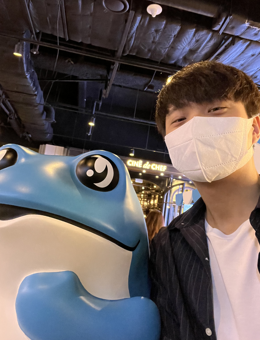

In [ ]:
display(transposed_img.resize((260,340)))

##s3 file load방식 변경

In [ ]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 5.2 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 9.2 MB 51.0 MB/s 
     |████████████████████████████████| 140 kB 53.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


In [ ]:
import boto3

In [ ]:
prefix_info = {
  'image' : "assets/photoDigm/userPicture/",
  'frame' : "assets/photoDigm/frame/",
  'photoDigm' : "assets/photoDigm/photoDigm/",
}
def connect_s3():
  with open("/content/drive/MyDrive/yeoreodigm/data_files/aws_access_info.json") as f:
    aws_access_info = json.load(f)
  return boto3.client('s3',aws_access_key_id=aws_access_info['AWS_ACCESS_KEY_ID'],
                                  aws_secret_access_key=aws_access_info['AWS_SECRET_ACCESS_KEY'],
                                  region_name=aws_access_info['REGION_NAME'])
    
#img_type : frame,image,photoDigm
def load_image1(client,img_type,file_name):
  bucket_name = "yeoreodigm-s3"
  prefix = prefix_info[img_type]

  
  entire_path = prefix + file_name  #디렉토리 경로를 모두 포함한 파일 경로
  #print("path : ",entire_path)
  result = client.list_objects(Bucket = bucket_name, Prefix=entire_path)

  for obj in result.get('Contents'):
    data = client.get_object(Bucket=bucket_name,Key=obj.get('Key'))
    data_content = data['Body'].read()
    #display(Image.open(io.BytesIO(data_content)))

    return Image.open(io.BytesIO(data_content))

In [ ]:
def connect_s3_2():
  with open("/content/drive/MyDrive/yeoreodigm/data_files/aws_access_info.json") as f:
    aws_access_info = json.load(f)
  return boto3.resource('s3',aws_access_key_id=aws_access_info['AWS_ACCESS_KEY_ID'],
                                  aws_secret_access_key=aws_access_info['AWS_SECRET_ACCESS_KEY'],
                                  region_name=aws_access_info['REGION_NAME'])

def load_image2(s3,img_type,file_name):
  bucket = "yeoreodigm-s3"
  prefix = prefix_info[img_type]
  entire_path = prefix + file_name
  Bucket = s3.Bucket(bucket)
  object_ = Bucket.Object(entire_path)
  response = object_.get()
  file_stream = response['Body']
  img = Image.open(file_stream)
  return img

In [ ]:
client = connect_s3()
for _ in range(10):
  jimin1_1 = load_image1(client,'image','jimin.png')
  jimin1_2 = load_image1(client,'image','jimin.jpeg')
  jimin1_3 = load_image1(client,'image','jimin2.png')
  jimin1_4 = load_image1(client,'image','jimin2.jpeg')

In [ ]:
s3 = connect_s3_2()
for _ in range(10):
  jimin2_1 = load_image2(s3,'image','jimin.png')
  jimin2_2 = load_image2(s3,'image','jimin.jpeg')
  jimin2_3 = load_image2(s3,'image','jimin2.png')
  jimin2_4 = load_image2(s3,'image','jimin2.jpeg')

In [ ]:
display(jimin2_3)

In [46]:
def upload_image(s3,img, img_type,key):
  bucket = 'yeoreodigm-s3'
  Bucket = s3.Bucket(bucket)
  save_path = prefix_info[img_type] + key
  object_ = Bucket.Object(save_path)

  file_stream = io.BytesIO()
  img.save(file_stream,format='jpeg') # binary data를 BytesIO로 변환해서 file stream에 담기
  object_.put(Body = file_stream.getvalue(),ContentType='image/jpeg')


In [61]:
img_path = "/content/drive/MyDrive/pillow_image_files/wonseok.jpeg"
img = Image.open(img_path)

In [62]:
img.format

'MPO'

In [ ]:
upload_image(s3,img,'image','upload_test3')

##업로드 및 로테이션 문제 해결 코드 종합하기

In [ ]:
img_path = "/content/drive/MyDrive/pillow_image_files/wonseok.jpeg"
img = Image.open(img_path)

In [ ]:
exif = img.getexif()
exif
for k in exif.keys():
  if k!=0x0112:
    exif[k] = None
    del exif[k]
new_exif = exif.tobytes()
img.info["exif"] = new_exif
transposed_img = ImageOps.exif_transpose(img)

In [44]:
type(transposed_img)

PIL.Image.Image

In [48]:
upload_image(s3,transposed_img,'image','upload_test5')

In [54]:
def load_image2(s3,img_type,file_name):
  bucket = "yeoreodigm-s3"
  prefix = prefix_info[img_type]
  entire_path = prefix + file_name
  Bucket = s3.Bucket(bucket)
  object_ = Bucket.Object(entire_path)
  response = object_.get()
  file_stream = response['Body']
  img = Image.open(file_stream)
  exif = img.getexif()
  
  for k in exif.keys():
    if k!=0x0112: # orientation information (0x0112),
      exif[k] = None
      del exif[k]
  new_exif = exif.tobytes()
  img.info["exif"] = new_exif
  transposed_img = ImageOps.exif_transpose(img)
  return transposed_img

In [50]:
img_name = "8a4768b4-7eea-4628-ac77-d48fab596dff.jpeg"
rotation_check = load_image2(s3,'image',img_name)

In [ ]:
display(rotation_check)

In [55]:
frame_img = load_image2(s3=s3,img_type='frame',file_name='frame1.png')

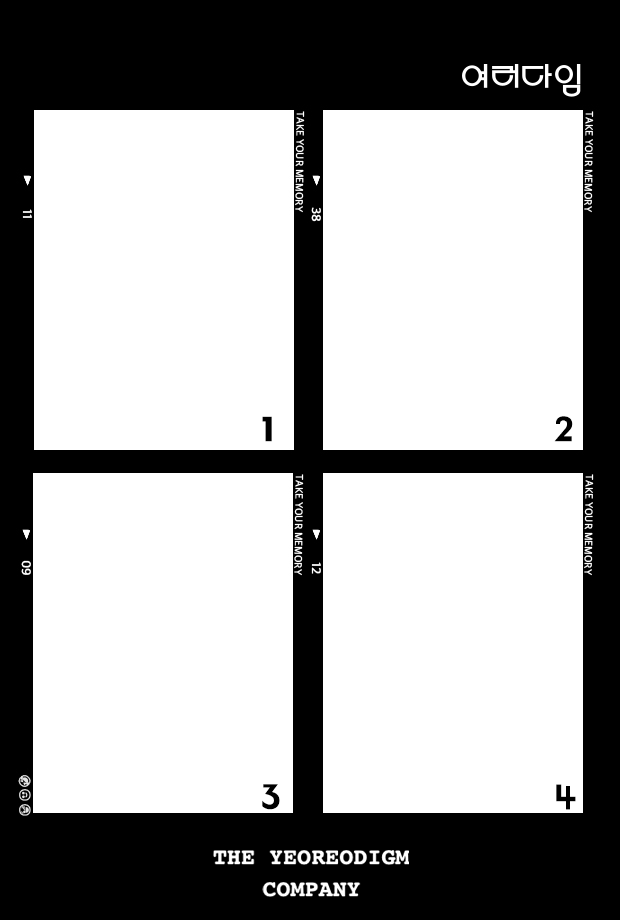

In [56]:
display(frame_img)